# Handwritten Text Recognition

## 1. Import Important packages

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random
import mxnet as mx
from mxnet import gluon

In [3]:
from utilities.iam_dataset import IAMDataset, resize_image, crop_image, crop_handwriting_page
from utilities.expand_bounding_box import expand_bounding_box

In [8]:
ctx=mx.cpu()

## 2. Create test dataset

In [4]:
test_ds = IAMDataset("form_original", train=False) #stores as arrays along with output text

Convert subject list


## 3. Plot Original Image

In [12]:
#Sets 4 images
figs_to_plot = 4
images = []
text = []

for i in range(0, figs_to_plot):
    n = int(random.random()*len(test_ds))
    image, _ = test_ds[n]
    images.append(image)
    text.append(_)

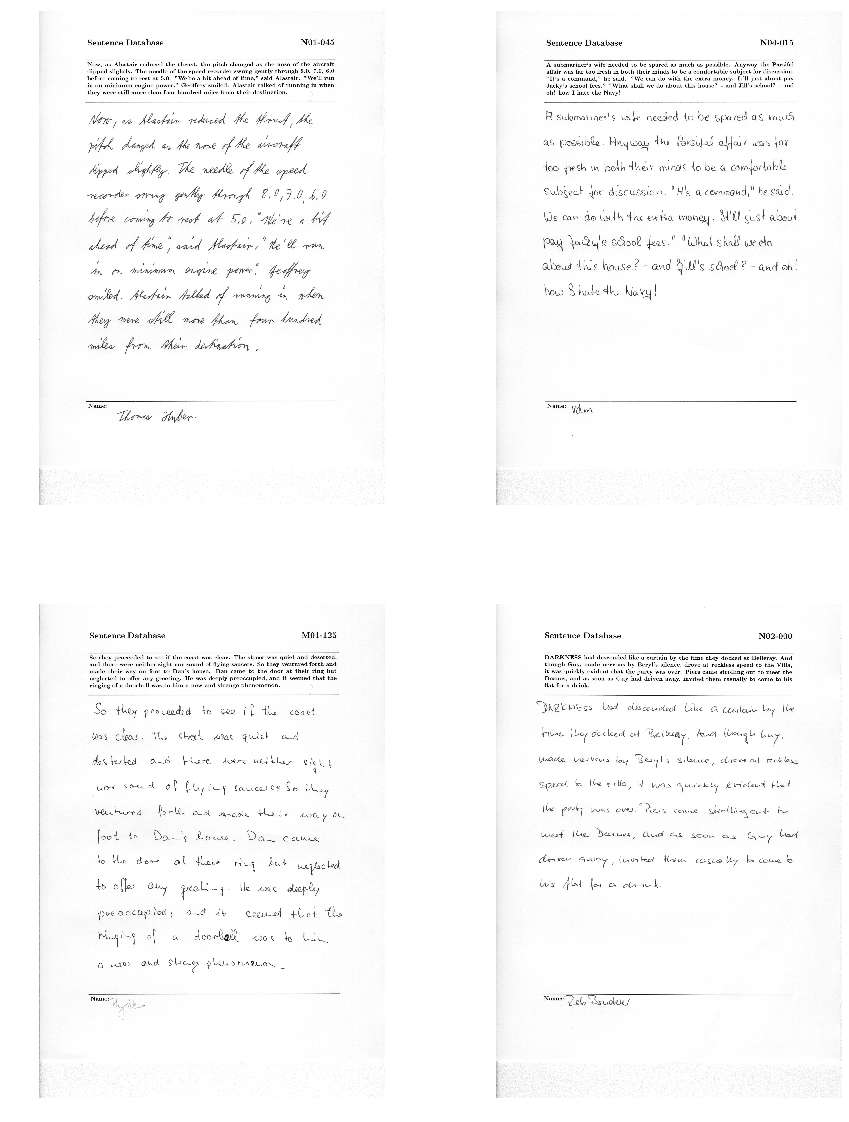

In [13]:
#shows 4 images
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 10 * len(images)/2))
for i, image in enumerate(images):
    y, x = int(i/2), int(i%2)
    axs[y, x].imshow(image, cmap='Greys_r')
    axs[y, x].axis('off')

## 4. Load Paragraph Segmentation Model

In [14]:
sym = mx.sym.load_json(open('model_export/cnn_mse_final-symbol.json', 'r').read())
paragraph_segmentation_net = gluon.nn.SymbolBlock(outputs=sym, inputs=mx.sym.var('data'))
paragraph_segmentation_net.load_parameters('model_export/cnn_mse_final-0093.params', ctx=ctx)

In [15]:
def paragraph_segmentation_transform(image, image_size):
    '''
    Function used for inference to resize the image for paragraph segmentation
    '''
    resized_image, _ = resize_image(image, image_size)
    
    resized_image = mx.nd.array(resized_image).expand_dims(axis=2)
    resized_image = mx.image.resize_short(resized_image, int(800/3))
    resized_image = resized_image.transpose([2, 0, 1])/255.
    resized_image = resized_image.expand_dims(axis=0)
    return resized_image

## 5. Run Paragraph Segmentation on test images

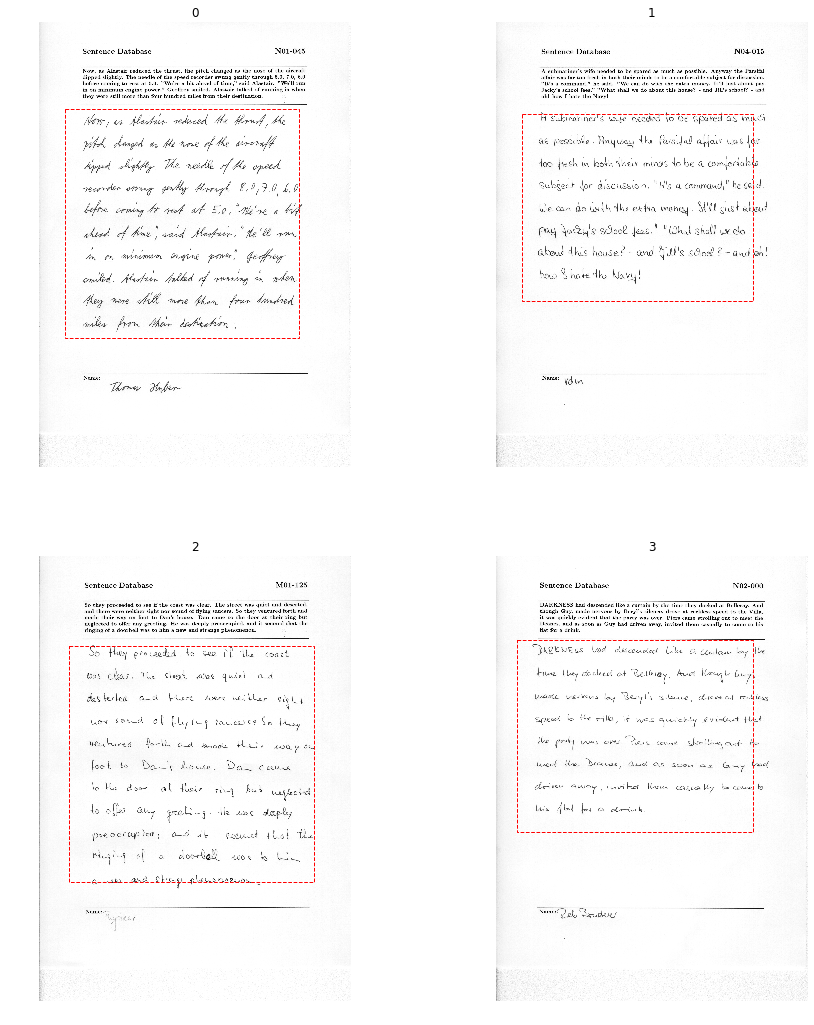

In [16]:
form_size = (1120, 800)

predicted_bbs = []

fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))
for i, image in enumerate(images):
    s_y, s_x = int(i/2), int(i%2)
    resized_image = paragraph_segmentation_transform(image, form_size)
    bb_predicted = paragraph_segmentation_net(resized_image.as_in_context(ctx))
    bb_predicted = bb_predicted[0].asnumpy()
    bb_predicted = expand_bounding_box(bb_predicted, expand_bb_scale_x=0.03,
                                           expand_bb_scale_y=0.03)
    predicted_bbs.append(bb_predicted)
    
    axs[s_y, s_x].imshow(image, cmap='Greys_r')
    axs[s_y, s_x].set_title("{}".format(i))

    (x, y, w, h) = bb_predicted
    image_h, image_w = image.shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r", ls="--")
    axs[s_y, s_x].add_patch(rect)
    axs[s_y, s_x].axis('off')

## 6. Crop form to paragraph

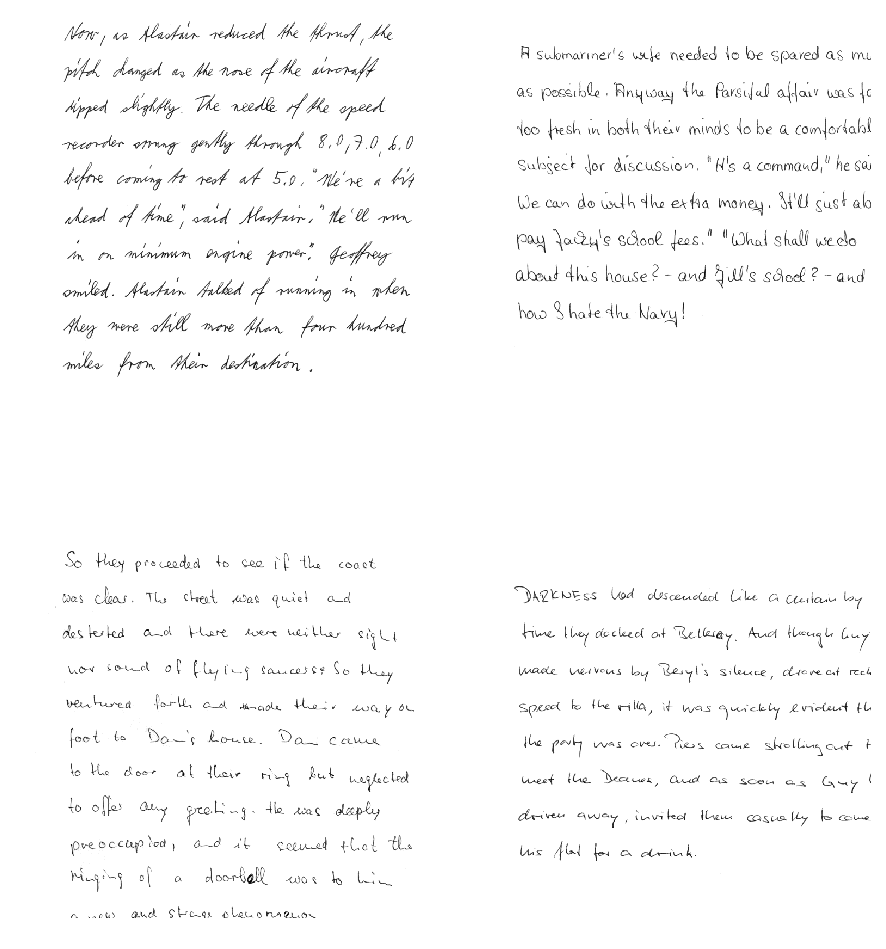

In [17]:
segmented_paragraph_size = (700, 700)
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))

paragraph_segmented_images = []

for i, image in enumerate(images):
    s_y, s_x = int(i/2), int(i%2)

    bb = predicted_bbs[i]
    image = crop_handwriting_page(image, bb, image_size=segmented_paragraph_size)
    paragraph_segmented_images.append(image)
    
    axs[s_y, s_x].imshow(image, cmap='Greys_r')
    axs[s_y, s_x].axis('off')